<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Autoencoders%2C_GANs_and_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Have to use Keras 2 instead of 3. To do that, set the `TF_USE_LEGACY_KERAS` environment variable to "1" and import the `tf_keras` package. This ensures that `tf.keras` points to `tf_keras`, which is Keras 2.*.


In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tf_keras

Requires TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

## Autoencoders, GANs and Diffusion Models
### Autoencoders
Autoencoders are artificial neural networks capable of learning dense
representations of the input data, called *latent representations* or *codings*,
without any supervision (i.e., the training set is unlabeled). Autoencoders are useful for dimensionality reduction especially for visualization purposes since the codings typically have a much lower dimensionality than the input data.

### Generative Adversarial Networks (GANs)
GANs are neural nets capable of generating data. GANs are widely used for super resolution (increasing the resolution of an image), colorization, powerful image editing (replacing photo bombers with a realistic background), predicting the next frames in a video, augmenting a dataset (to train other models, generating other types
of data (such as text, audio, and time series), identifying the weaknesses in
other models to strengthen them, and more.

### Diffusion Models
Similar to GANs, but is able to generate more diverse and higher-quality images while also being much easier to train. However, diffusion models are slower to run.

Autoencoders, GANs, and diffusion models are all unsupervised, they all
learn latent representations, they can all be used as generative models, and
they have many similar applications. However, they work very differently:

- **Autoencoders** learn to copy inputs to outputs, but applying constraints like reducing the latent space size or adding noise forces them to find efficient data representations instead of simply copying the data. These constraints help the autoencoder learn meaningful patterns.

- **Generative Adversarial Networks (GANs)** consist of a generator that creates data resembling real samples and a discriminator that identifies fake data. The two networks compete during training, improving each other. This adversarial training method is considered a major breakthrough in deep learning, with Yann LeCun calling it the most interesting idea in machine learning of the past decade.

- **Denoising Diffusion Probabilistic Models (DDPMs)** remove noise from images step by step. Starting with an image filled with Gaussian noise, the model refines it over multiple iterations to generate high-quality images that resemble the training data but are not identical.

## Performing Principal Component Analysis (PCA) with an Undercomplete Linear Autoencoder
If the autoencoder uses only linear activations and the cost function is the
mean squared error (MSE), then it ends up performing principal component
analysis.

The following code builds a simple linear autoencoder to perform PCA on a
3D dataset, projecting it to 2D:

In [5]:
import tensorflow as tf

tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Things to note from code:

- The autoencoder was organized into 2 subcomponents: the encoder and the decoder. Both are regular `Sequential` models with a single `Dense` layer each. The autoencoder is a `Sequential` model as well and it contains the encoder followed by the decoder.
- The autoencoder's number of outputs is equal to the number of inputs (i.e., 3).
- To perform PCA, we do not use any activation function (i.e., all neurons are linear) and the cost function is MSE, since PCA is a linear transformation.

Let's train a simple generated 3D dataset and use it to encode that dataset (i.e., project it to 2D):

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 5ms/step


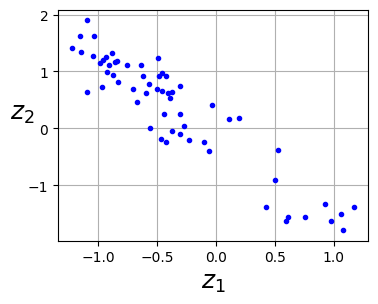

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

The autoencoder managed to find the best 2D plane to project the data onto, preserving as much variance in the data as it could.<br>
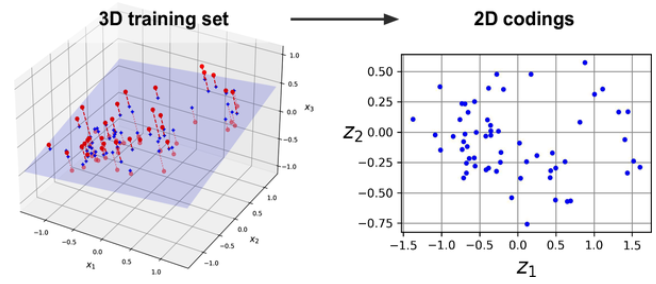

## Stacked Autoencoders
Stacked Autoencoders are autoencoders with multiple hidden layers. Having more layers allows the autoencoder to learn more complex codings.

### Implementing a Stacked Autoencoder using Keras
A stacked autoencoder can be implemented like a regular deep MLP:

In [8]:
# Loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Build and Train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 Stacked Autoencoders):

In [9]:
tf.random.set_seed(42)

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 4ms/step - loss: 0.0244 - val_loss: 0.0190
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 7/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0151 - val_loss: 0.0153
Epoch 8/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 9/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 10/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.01

Walkthrough of code:
- Similar to earlier, the autoencoder model was split into 2 submodels: the encoder and decoder.
- The encoder takes 28×28 pixel grayscale images, flattens them so
that each image is represented as a vector of size 784, then processes
these vectors through two Dense layers of diminishing sizes (100 units then 30 units), both using the ReLU activation function. For each input image, the encoder outputs a vector of size 30.
- The decoder takes codings of size 30 (output by the encoder) and processes them through two Dense layers of increasing sizes (100 units then 784 units), and it reshapes the final vectors into 28 × 28 arrays so
the decoder’s outputs have the same shape as the encoder’s inputs.
- When compiling the stacked autoencoder, we use the MSE loss and Nadam optimization.
- Finally, we train the model using X_train as both the inputs and the targets. Similarly, we use X_valid as both the validation inputs and targets.

## Visualizing the Reconstructions
To ensure that an encoder is properly trained, one way is to compare the inputs and outputs. Let's plot a few images from the validation set, as well as their reconstructions:

1/1 [==============================] - 0s 69ms/step


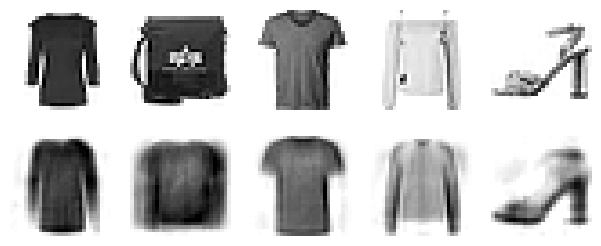

In [10]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

The reconstructions are recognizable, but too lossy. The model might have to be trained longer, or make the encoder and decoder deeper, or make the encodings larger. But if the network is too powerful, it will manage to make perfect reconstructions without having learned any useful patterns in the data, hence just stick with the model for now.

### Visualizing the Fashion MNIST Dataset
Now that we have a trained stacked autoencoder, we can use it to reduce the dataset's dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one advantage of autoencoders is that they can handle large datasets with many instances and features. So, one
strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for
visualization. Let’s use this strategy to visualize Fashion MNIST. First we’ll use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we’ll use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

In [11]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


Now we can plot the dataset:

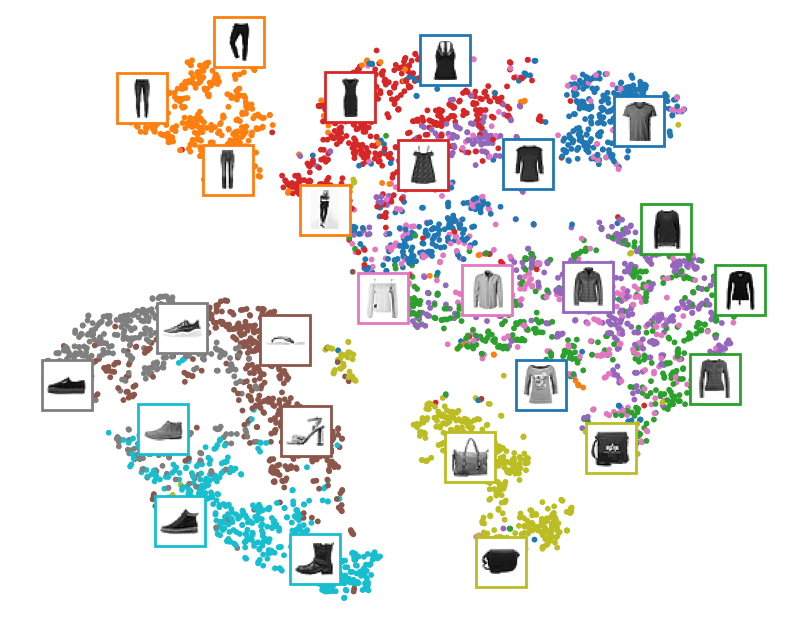

In [12]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

The t-SNE algorithm identified several clusters that
match the classes reasonably well (each class is represented by a different color).

### Unsupervised Pretraining using Stacked Autoencoders
If we have a large dataset but most of it is unlabeled, we can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for our actual task and train it using the labeled data. When training the classifier, if there are not much labeled training data, we can freeze the pretrained layers (at least the lower ones).

### Tying Weights
When an autoencoder is neatly symmetrical, a common technique is to *tie* the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting.

To do so, we need to define a custom layer:

In [13]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

The custom layer acts like a regular `Dense` layer but it uses another `Dense` layer's weights, transposed. However, it uses its own bias vector.

Now, we can build a new stacked autoencoder:

In [14]:
tf.random.set_seed(42)

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# Compiles and fits the model
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0225 - val_loss: 0.0170
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0143 - val_loss: 0.0143
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0136 - val_loss: 0.0137
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.013

The model achieved similar losses as the previous model, but using almost half the paramters.

## Convolutional Autoencoders
When dealing with images, convolutional neural networks are far better suited than dense networks. However, if we want to use autoencoders for images, we need to build a *Convolutional Autoencoder*. This autoencoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this we can use transpose convolutional layers.

The following code builds a Convolutional Autoencoder:

In [15]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# Compiles and fits the model
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 8ms/step - loss: 0.0310 - val_loss: 0.0212
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0193 - val_loss: 0.0180
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0172 - val_loss: 0.0174
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0160 - val_loss: 0.0155
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 6/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 8/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0137 - val_loss: 0.0141
Epoch 9/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 10/10
1719/1719 [==============================] - 12s 7ms/step - l

Visualization of the reconstruction:

1/1 [==============================] - 0s 298ms/step


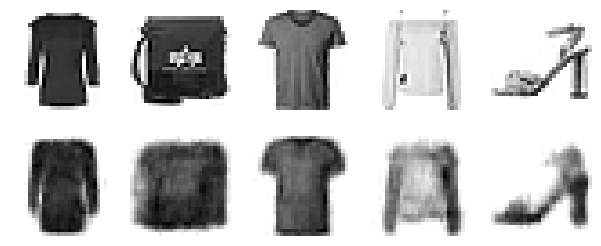

In [16]:
plot_reconstructions(conv_ae)
plt.show()

## Denoising Autoencoders
To force the autoencoder to learn useful features, one way is to add noise to its inputs, then train it to recover the original, noise-free inputs.

The implementation is straightforward: it is a regular stacked autoencoder with an additional `Dropout layer` applied to the encoder’s inputs (or we could use a `GaussianNoise` layer instead). Recall that the `Dropout` layer is only active during training (and so is the `GaussianNoise` layer):

In [17]:
tf.random.set_seed(42)

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# Compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 4ms/step - loss: 0.0280 - val_loss: 0.0207
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0215 - val_loss: 0.0191
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0203 - val_loss: 0.0182
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0196 - val_loss: 0.0177
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0188 - val_loss: 0.0172
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0186 - val_loss: 0.0169
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0184 - val_loss: 0.0165
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.01

Visualize the reconstructions:

1/1 [==============================] - 0s 93ms/step


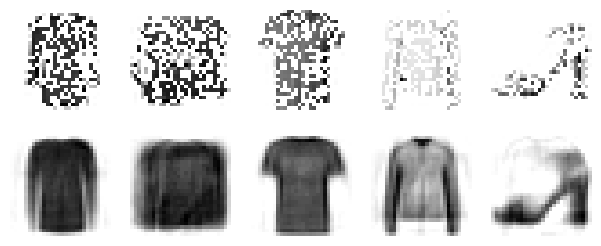

In [18]:
tf.random.set_seed(42)

dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

The output shows a few noisy images (with half the pixels turned off) and the images reconstructed by the dropout-based denoising autoencoder. Not only can denoising autoencoders be used for data visualization or unsupervised pretraining, it can also remove noise from images.

## Sparse Autoencoders
Another kind of constraint that often leads to good feature extraction is *sparsity*: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large
coding layer (e.g., with 300 units), and add some ℓ<sub>1</sub> regularization to the coding layer’s activations. The decoder is just a regular decoder:


In [19]:
tf.random.set_seed(42)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# Compiles and fits the model
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0277 - val_loss: 0.0193
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0172 - val_loss: 0.0160
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 9/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.011

This `ActivityRegularization` layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of the absolute values of its inputs. This only affects training.

Visualization of the reconstructions:

1/1 [==============================] - 0s 66ms/step


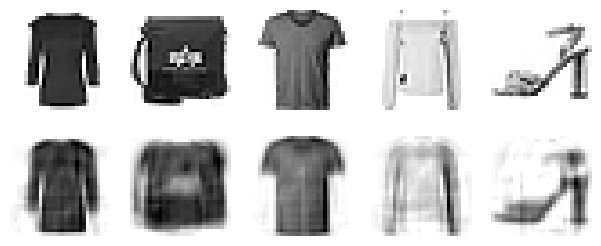

In [20]:
plot_reconstructions(sparse_l1_ae)
plt.show()

Now we have all we need to implement a sparse autoencoder based on the KL divergence. First, create a custom regularizer to apply KL divergence regularization:

In [21]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now we can build the sparse autoencoder, using the
`KLDivergenceRegularizer` for the coding layer’s activations:

In [22]:
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# Compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 5ms/step - loss: 0.0257 - val_loss: 0.0171
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0150 - val_loss: 0.0135
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0126 - val_loss: 0.0140
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 8/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 9/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 10/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.00

Visualization of the reconstruction:

1/1 [==============================] - 0s 97ms/step


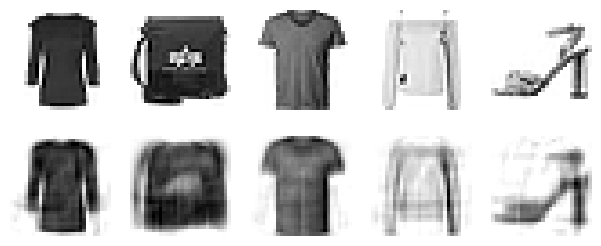

In [23]:
plot_reconstructions(sparse_kl_ae)
plt.show()

## Variational Autoencoders (VAEs)
VAEs are different from all the autoencoders introduced previously in these ways:
- They are *probabilistic autoencoders*, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).
- They are *generative autoencoders*, meaning that they can generate new instances that look like they were sampled from the training set.

To build VAEs, first we need a custom layer to sample the codings, given μ and γ:

In [24]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

This `Sampling` layer takes 2 inputs: mean (μ) and log_var (γ). It uses the function `tf.random.normal()` to sample a random vector from the Gaussian distribution with mean=0 and standard deviation=1.  Then it multiplies it by exp(γ / 2) and finally adds μ and returns the result.

Next, we can create the encoder using the functional API since the model is not entirely sequential:

In [25]:
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

Note that the Dense layers that output codings_mean (μ) and codings_log_var (γ) have the same inputs (i.e., the outputs of the second Dense layer). We then pass both `codings_mean` and `codings_log_var` to the Sampling layer. Finally, the `variational_encoder` model has three outputs. Only the codings are required, but we add `codings_mean` and `codings_log_var` as well, in case we want to inspect their values.

Now let’s build the decoder:

In [26]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

For this decoder, we could have used the sequential API instead of the functional API, since it is really just a simple stack of layers, virtually identical to many of the decoders we have built so far.

Finally, let’s build the variational autoencoder model:

In [27]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

We ignore the first two outputs of the encoder (we only want to feed the codings to the decoder).


Lastly, we must add the latent loss and the reconstruction loss:

In [28]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

Finally, we can compile and fit the autoencoder:

In [29]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 7s 7ms/step - loss: 0.0502 - val_loss: 0.0384
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0365 - val_loss: 0.0357
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0346 - val_loss: 0.0347
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0337 - val_loss: 0.0337
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0331 - val_loss: 0.0332
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0327 - val_loss: 0.0328
Epoch 7/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0324 - val_loss: 0.0328
Epoch 8/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0321 - val_loss: 0.0325
Epoch 9/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0319 - val_loss: 0.0321
Epoch 10/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0318 - val_loss: 0.0321

1/1 [==============================] - 0s 115ms/step


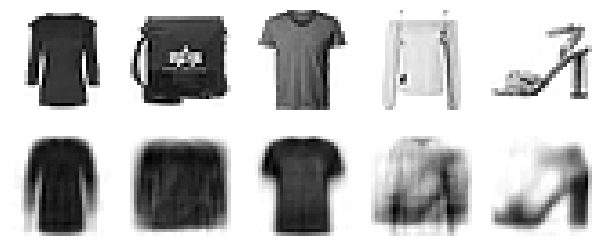

In [30]:
plot_reconstructions(variational_ae)
plt.show()

## Generating Fashion MNIST Images
Let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

In [31]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

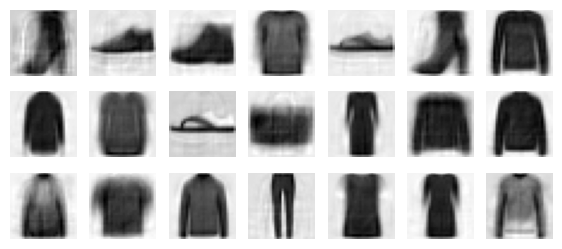

In [32]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

Variational autoencoders make it possible to perform *semantic interpolation*: instead of interpolating between two images at the pixel level, which would look as if the two images were just overlaid, we can
interpolate at the codings level. For example, let’s take a few codings along an arbitrary line in latent space and decode them. We get a sequence of images that gradually go from pants to sweaters:

In [33]:
tf.random.set_seed(42)

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

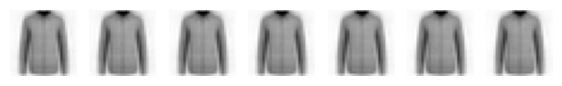

In [34]:
plot_multiple_images(images)
plt.show()

## Generative Adversarial Networks (GANs)
A GAN is composed of 2 neural networks:
- **Generator**:
 - Takes a random distribution as input (typically Gaussian) and outputs
some data—typically, an image. Can think of the random inputs as the latent representations (i.e., codings) of the image to be generated. The generator offers the same functionality as a decoder in a variational autoencoder, and it can be used in the same way to generate new images: just feed it some Gaussian noise, and it outputs a brand-new image.

- **Discriminator**:
 - Takes either a fake image from the generator or a real image from the training set as input, and guess whether the input image is fake or real.<br>

 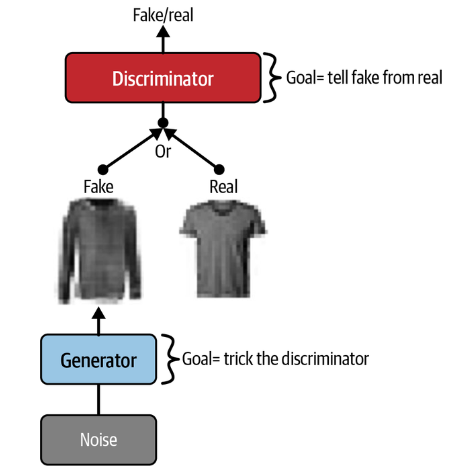

To build a simple GAN for Fashion MNIST, we first need to build the generator and the discriminator. The generator is similar to an autoencoder's decoder and the discriminator is a regular binary classifier: it takes an input and ends with a `Dense` layer containing a single unit and using the sigmoid activation function. For the
second phase of each training iteration, we also need the full GAN model
containing the generator followed by the discriminator:

In [35]:
tf.random.set_seed(42)

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

Next, we need to compile these models. As the discriminator is a binary
classifier, we can naturally use the binary cross-entropy loss. The gan
model is also a binary classifier, so it can use the binary cross-entropy loss
as well. However, the generator will only be trained through the gan model,
so we do not need to compile it at all. More importantly, the discriminator should
not be trained during the second phase, so we make it non-trainable before
compiling the gan model:

In [36]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Since the training loop is unusual, we cannot use the regular `fit()` method.
Instead, we will write a custom training loop. For this, we first need to
create a `Dataset` to iterate through the images:

In [37]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

We are now ready to write the training loop. Let’s wrap it in a `train_gan()`
function:

Epoch 1/25


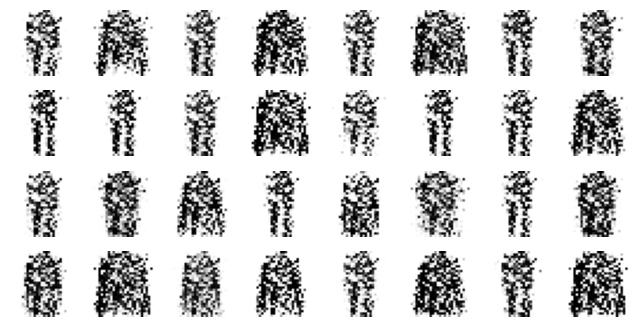

Epoch 2/25


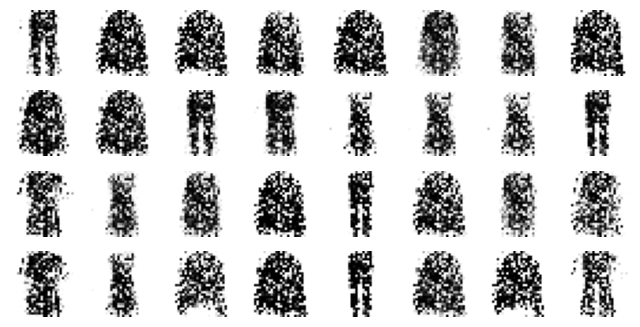

Epoch 3/25


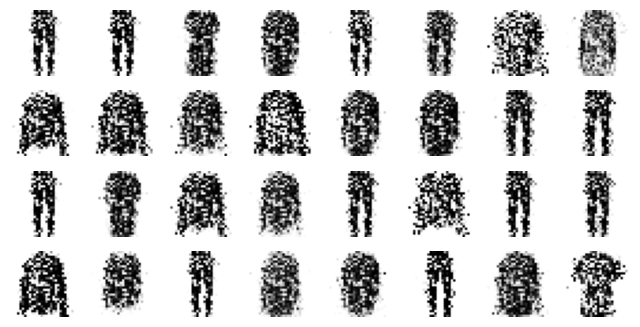

Epoch 4/25


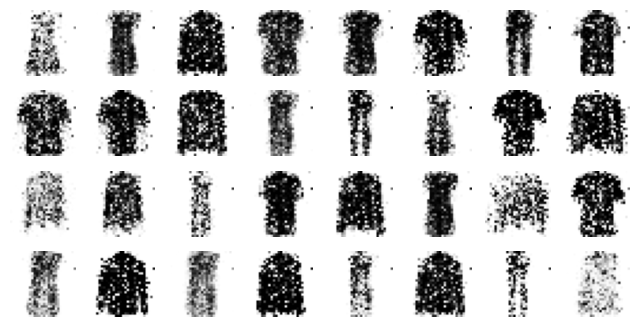

Epoch 5/25


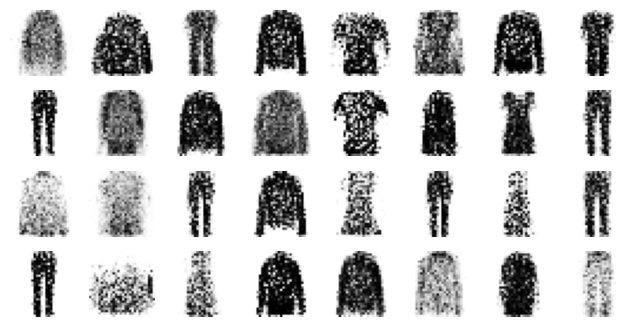

Epoch 6/25


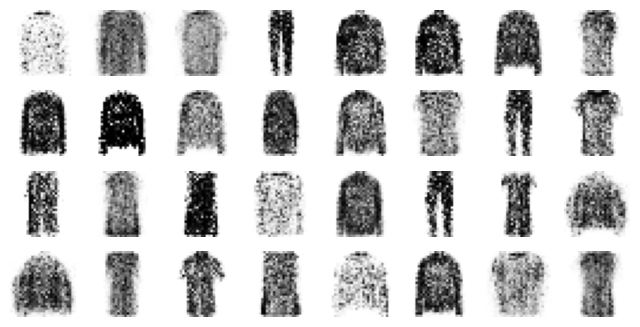

Epoch 7/25


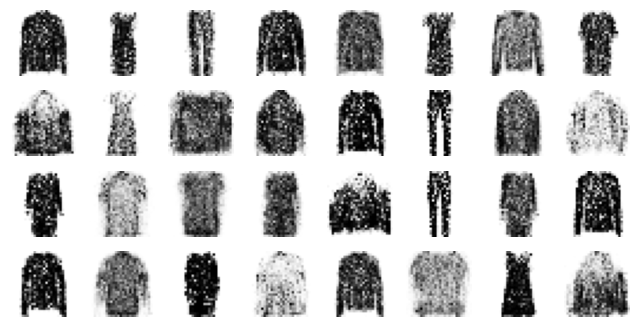

Epoch 8/25


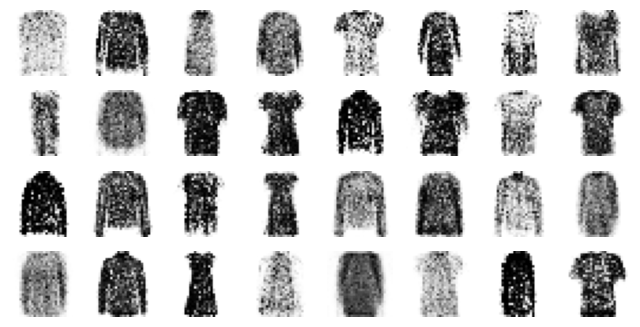

Epoch 9/25


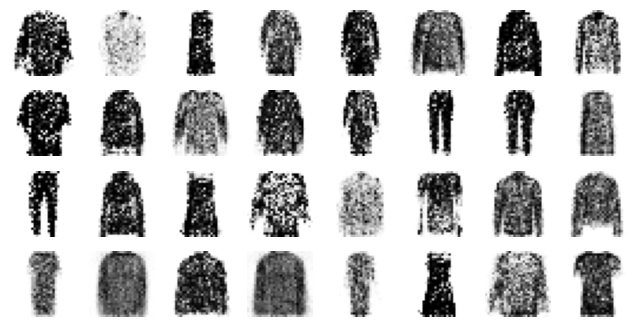

Epoch 10/25


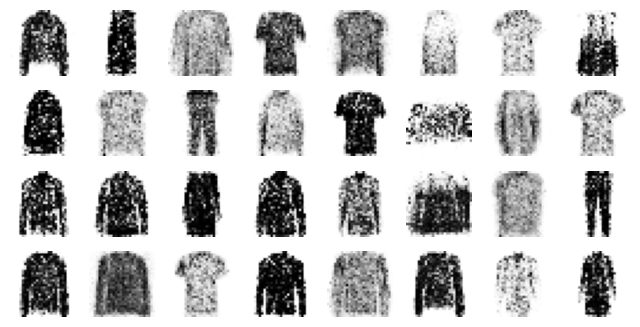

Epoch 11/25


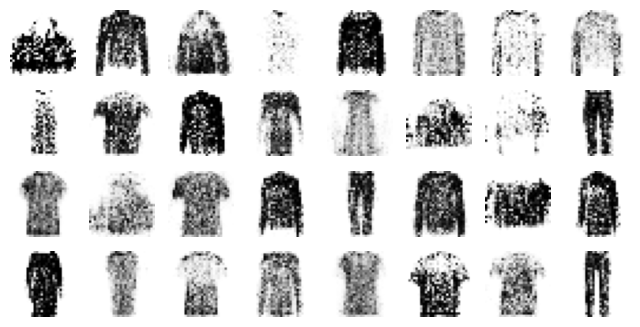

Epoch 12/25


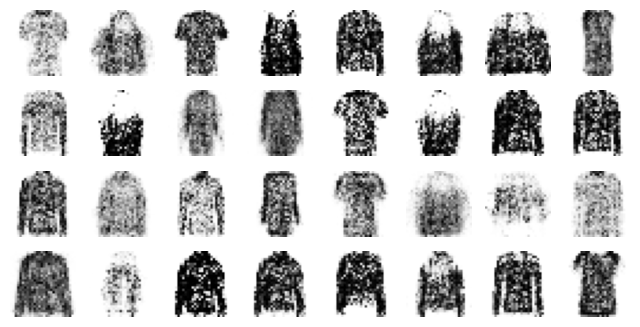

Epoch 13/25


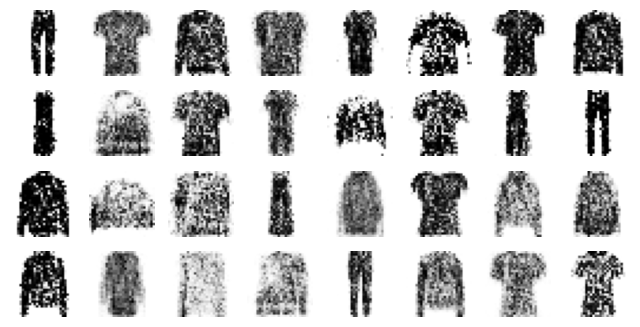

Epoch 14/25


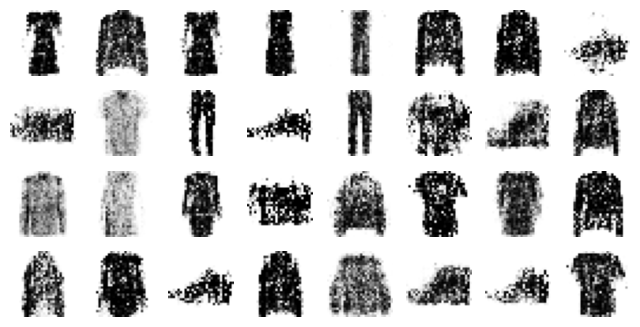

Epoch 15/25


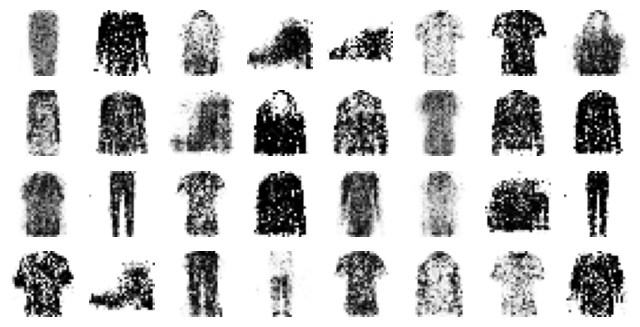

Epoch 16/25


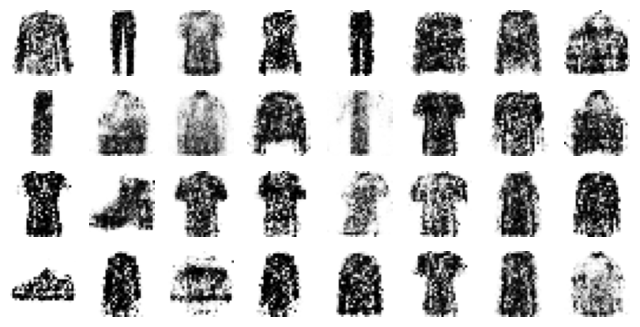

Epoch 17/25


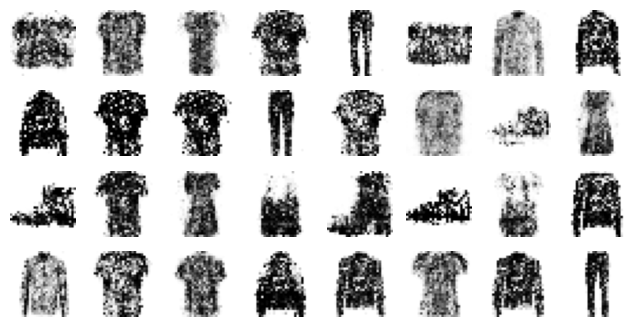

Epoch 18/25


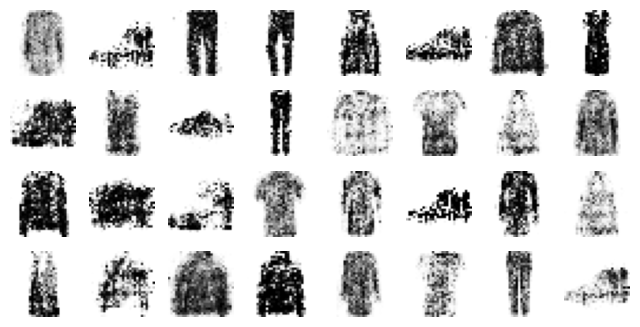

Epoch 19/25


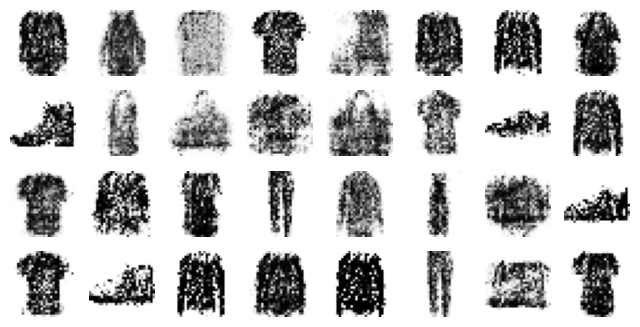

Epoch 20/25


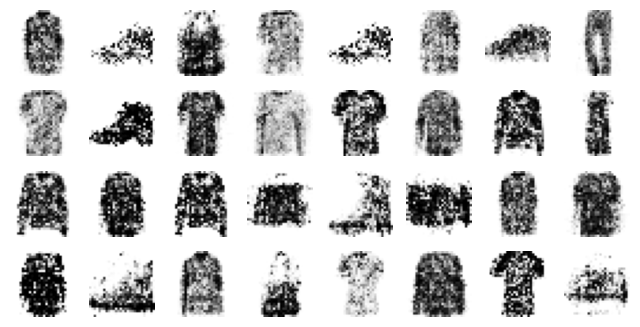

Epoch 21/25


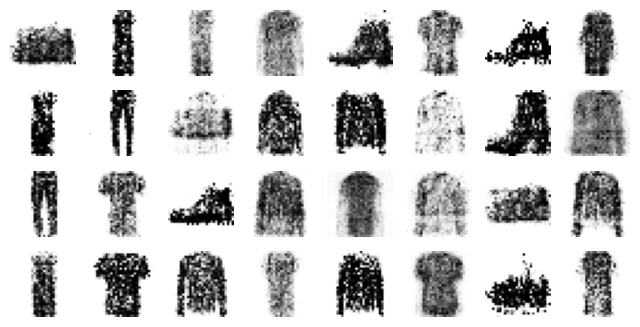

Epoch 22/25


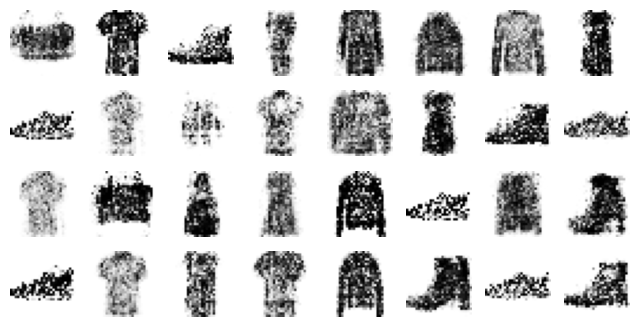

Epoch 23/25


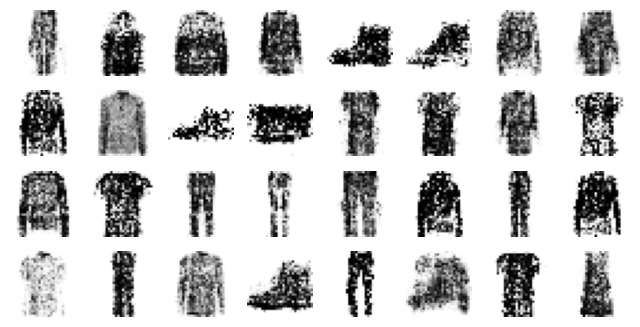

Epoch 24/25


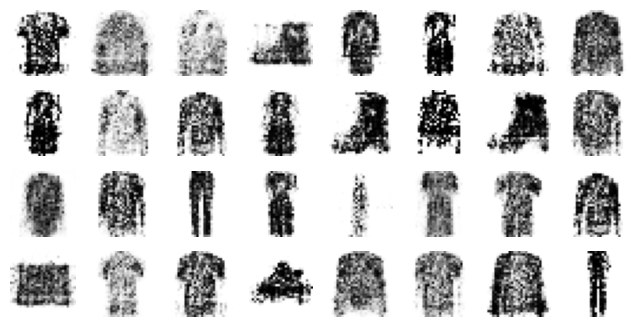

Epoch 25/25


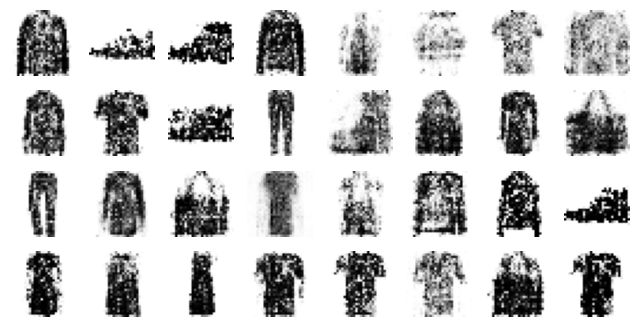

In [38]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # Phase 1 - Training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Phase 2 - Training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # Plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

train_gan(gan, dataset, batch_size, codings_size, n_epochs=25)

There are 2 phases at each iteration:
- In Phase 1, we feed Gaussian noise to the generator to produce fake
images, and we complete this batch by concatenating an equal number
of real images. The targets `y1` are set to 0 for fake images and 1 for
real images. Then we train the discriminator on this batch.
- In Phase 2, we feed the GAN some Gaussian noise. Its generator
will start by producing fake images, then the discriminator will try to
guess whether these images are fake or real. In this phase, we are
trying to improve the generator, which means that we want the
discriminator to fail: this is why the targets `y2` are all set to 1, although
the images are fake.

After training, we can randomly sample some codings from a
Gaussian distribution, and feed them to the generator to produce new
images:

In [39]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 1s 1s/step


Visualization of the reconstructions:

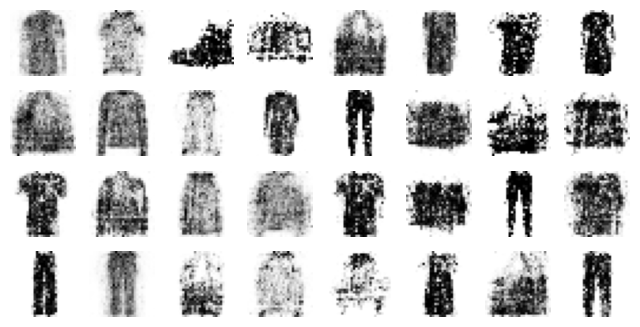

In [40]:
plot_multiple_images(generated_images, 8)
plt.show()

### Deep Convolutional GANs
Main guidelines for building stable deep convolutional GANs (DCGANs):
- Replace any pooling layers with strided convolutions (in the
discriminator) and transposed convolutions (in the generator).
- Use batch normalization in both the generator and the discriminator,
except in the generator’s output layer and the discriminator’s input
layer.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in the generator for all layers except the output
layer, which should use tanh.
- Use leaky ReLU activation in the discriminator for all layers.

These guidelines works in many cases but not always. Different hyperparameters should be experimented.

The following code is a small DCGAN what works reasonably well with Fashion MNIST:

In [41]:
tf.random.set_seed(42)

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

Compile the discriminator and the GAN:

In [42]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Before training the GAN, we need to rescale the training set and reshape it to add the channel dimension:

In [43]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

Generate the dataset and train the GAN:

Epoch 1/25


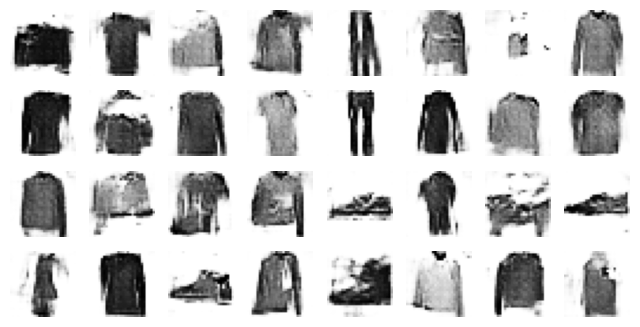

Epoch 2/25


In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=25)

Visualization of reconstructions:

In [ ]:
tf.random.set_seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)

## Diffusion Models
### How does a Denoising Diffusion Probabilistic Model (DDPM) works?
Suppose we start with a picture
of a cat noted **x<sub>0</sub>**, and at each time
step **t** we add a little bit of Gaussian noise to the image, with **mean 0** and
**variance β<sub>t</sub>**. This noise is independent for each pixel: we call it *isotropic*.
We first obtain the image **x<sub>1</sub>**, then **x<sub>2</sub>** , and so on, until the cat is completely
hidden by the noise, impossible to see. The last time step is noted **T**. In the
original DDPM paper, the authors used **T = 1,000**, and they scheduled the
variance **β<sub>t</sub>** in such a way that the cat signal fades linearly between time
steps 0 and **T**. In the improved DDPM paper, **T** was bumped up to 4,000,
and the variance schedule was tweaked to change more slowly at the
beginning and at the end. In short, we’re gradually drowning the cat in
noise: this is called the **forward process**.


The first thing we need to do is to code the forward process. For this, we will first need to implement the variance schedule. How can be control how fast the cat dissapears? Let's first create a small function to compute **α<sub>t</sub>**, **β<sub>t</sub>**, and **α<sub>t</sub>**
, and call it with **T =4,000**:

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)

T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

To train the model to reverse the diffusion process, we will need noisy images from different time steps of the forward process. For this, let's create a `prepare_batch()` function that will take a batch of clean images from the dataset and prepare them:

In [ ]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

Next, we’ll create a training dataset and a validation set that will apply the
`prepare_batch()` function to every batch. As earlier, `X_train` and
`X_valid` contain the Fashion MNIST images with pixel values ranging
from 0 to 1:

In [ ]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)

train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

Implement a custom Time Encoding layer:

In [ ]:
embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

Now we’re ready to build the actual diffusion model itself. It can be any
model you want, as long as it takes the noisy images and time steps as
inputs, and predicts the noise to subtract from the input images:

In [ ]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

Next we can train the model and use Huber loss:

In [ ]:
tf.random.set_seed(42)

model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")
history = model.fit(train_set, validation_data=valid_set, epochs=100)

Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time **T**. Then we use the model to predict the image at time **T - 1**, then we call it again to get **T - 2**, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset:


In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # Show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)

X_gen = generate(model)  # generated images

Visualization of the reconstruction:

In [ ]:
plot_multiple_images(X_gen.numpy(), 8)
plt.show()